In [14]:
# Original https://bm371613.github.io/conditional-flow-matching/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
from torch import nn
from tqdm import tqdm
from zuko.utils import odeint

plt.rcParams["animation.html"] = "jshtml"

torch.cuda.set_device(0)

In [15]:
# Creates a dataset of complex points in the shape of a happy face :)
def create_dataset(size: int = 100_000):
    # Creates a set of complex points of magnitude 1 (unit circle) and random phase, essentialy lots of points in the unit circle
    complex_points = torch.polar(torch.tensor(1.0), torch.rand(size) * 2 * torch.pi)
    # Stacks the real and imaginary parts of the complex points, so that each row is a complex number
    X = torch.stack((complex_points.real, complex_points.imag)).T
    
    # Moves all the points on the upper side of the circle to 2 points (eyes)
    upper = complex_points.imag > 0
    left = complex_points.real < 0
    X[upper, 1] = 0.5
    X[upper & left, 0] = -0.5
    X[upper & ~left, 0] = 0.5

    # Adds noise to the points, more noise to the upper points for the eyes and less noise to the lower points for the mouth
    noise = torch.zeros_like(X)
    noise[upper] = torch.randn_like(noise[upper]) * 0.10
    noise[~upper] = torch.randn_like(noise[~upper]) * 0.05
    X += noise
    
    # Normalizes the data so it has 0 mean and 1 std
    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    return X + noise
    
dataset = create_dataset()
noise = torch.randn_like(dataset)

dataset.shape

torch.Size([100000, 2])

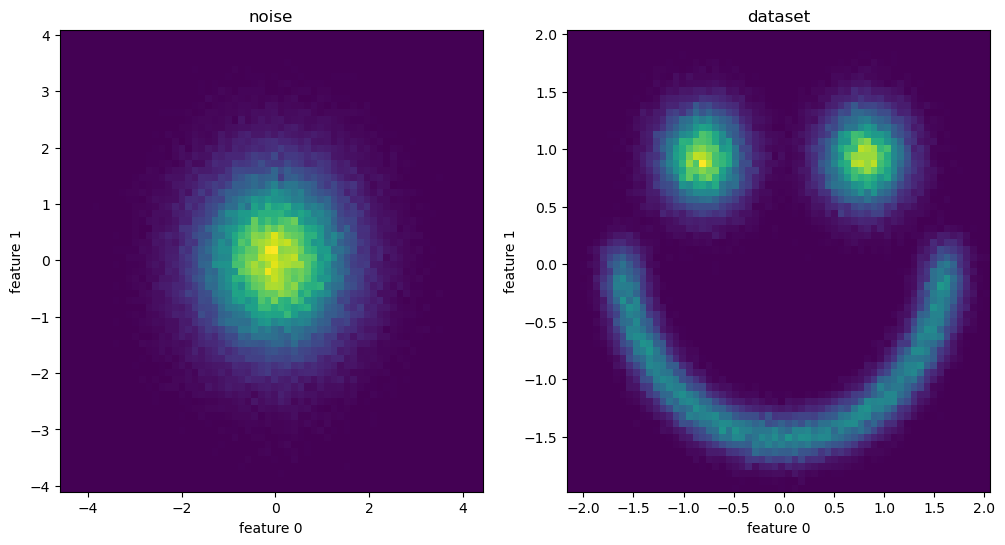

In [16]:
# Plots the dataset
def plot_dataset(X, bins, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.hist2d(*X.T, bins=bins)
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set(**kwargs)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_dataset(noise, bins=64, ax=axs[0], title='noise')
plot_dataset(dataset, bins=64, ax=axs[1], title='dataset')

In [19]:
# From the original notebook:
# Let's consider a process of data transformation with time flowing from 0 to 1.
# At 0, we start with the random noise. At 1, we hope to arrive at the target distribution - our dataset.

#For every
#   time value between 0 and 1
#   point in our feature space
# the flow model specifies a direction in the feature space.

class FlowModel(nn.Module):

    def forward(self, X, time):
        raise NotImplementedError()

class ExampleFlow(FlowModel):

    def forward(self, X, time):
        result = torch.zeros_like(X)
        result[:, 0] = -X[:, 0] * time
        result[:, 1] = X[:, 1] * (1 - time)
        return result

ExampleFlow()(torch.tensor([[.2, .4], [.7, .9]]), time=torch.tensor([.6]))

tensor([[-0.1200,  0.1600],
        [-0.4200,  0.3600]])

In [21]:
# Flow visualization

@torch.no_grad()
def plot_flow_at_time(flow_model, time, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    points = torch.linspace(-1, 1, 10)
    flow_input = torch.cartesian_prod(points, points) # grid of points
    print(f"{time=}")
    print(f"{flow_input.shape=}")
    print(f"{torch.full(flow_input.shape[:1])=}")
    flow_output = flow_model(flow_input, time=torch.full(flow_input.shape[:1], time))
    ax.quiver(
        torch.stack(torch.chunk(flow_input[:, 0], len(points))).numpy(), # input real coordinates
        torch.stack(torch.chunk(flow_input[:, 1], len(points))).numpy(), # input imaginary coordinates
        torch.stack(torch.chunk(flow_output[:, 0], len(points))).numpy(), # output real coordinates
        torch.stack(torch.chunk(flow_output[:, 1], len(points))).numpy(), # output imaginary coordinates
        scale=len(points),
    )
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set(**kwargs)


def animate_flow(flow_model, frames: int = 20):

    def plot_frame(time):
        plt.cla()
        plot_flow_at_time(flow_model, time=time, title=f'flow at time={time:.2f}')
    
    fig = plt.figure(figsize=(8, 8))
    animation = FuncAnimation(fig, plot_frame, frames=np.linspace(0, 1, frames))
    html = HTML(animation.to_html5_video())
    plt.close()
    return html
    
animate_flow(ExampleFlow())

### Notes on Differential Equations and flow visualization

* The flow model can be seen as a Differential Equations system, where the flow model is a function of the rate of change (derivative) of the initial data distribution x_0
* Given that the flow model is a first order diferential equation, is an Ordinary Differential Equation (ODE), i.e the differential equation has no partial derivatives
* We need to solve the diferential equation system with initial conditions x_0 and t_0 to get the new data distribution function phi(x) evaluated a t_1 to get the final data distribution x_1. An ODE solver (zuko.odeint) is used for this 

In [20]:
# Visualize the flow of the gaussian noise dataset through the flow model

@torch.no_grad()
def run_flow(flow_model, x_0, t_0, t_1, device='cpu'):
    def f(t: float, x):
        return flow_model(x, time=torch.full(x.shape[:1], t, device=device))

    return odeint(f, x_0, t_0, t_1, phi=flow_model.parameters()) #Ordinart differential equation solver, gives the solving function evaluated at time t_1


def animate_flow_run(flow_model, X, frames=20, device='cpu'):
    bins = [
        np.linspace(X[:, 0].min().cpu(), X[:, 0].max().cpu(), 128),
        np.linspace(X[:, 1].min().cpu(), X[:, 1].max().cpu(), 128),
    ]

    def plot_frame(time):
        plt.cla()
        plot_dataset(run_flow(flow_model, X, 0, time, device=device).cpu(), bins=bins, title=f'distribution at time {time:.2f}')
    
    fig = plt.figure(figsize=(8, 8))
    animation = FuncAnimation(fig, plot_frame, frames=np.linspace(0, 1, frames))
    html = HTML(animation.to_html5_video())
    plt.close()
    return html


animate_flow_run(ExampleFlow(), noise)

In [ ]:
# Trainable neural network flow model

class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        emb = self.freqs * t[..., None]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class FlowNeuralNetwork(FlowModel):

    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features)


    def forward(self, X, time):
        X = torch.cat([X, self.time_embedding(time)], axis=1)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

In [ ]:
# Visualize the flow with parameters initialized randomly

model = FlowNeuralNetwork(n_features=2)
animate_flow(model)